In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
img = cv2.imread("./test_images/sharapova.png")
img.shape

(254, 350, 3)

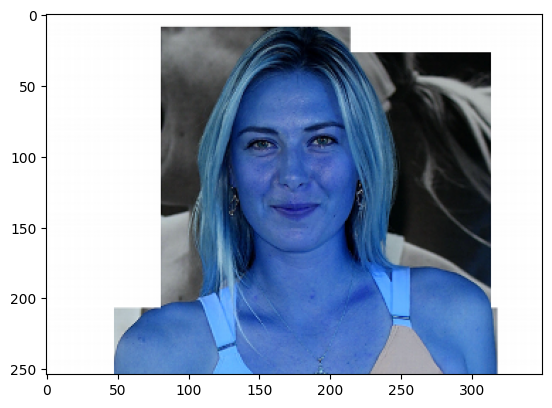

In [4]:
plt.imshow(img)

In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(254, 350)

In [6]:
gray

array([[255, 254, 254, ..., 255, 255, 254],
       [255, 254, 254, ..., 255, 255, 254],
       [255, 254, 254, ..., 255, 255, 254],
       ...,
       [255, 254, 254, ..., 255, 255, 254],
       [255, 254, 254, ..., 255, 255, 254],
       [254, 253, 253, ..., 254, 254, 253]], shape=(254, 350), dtype=uint8)

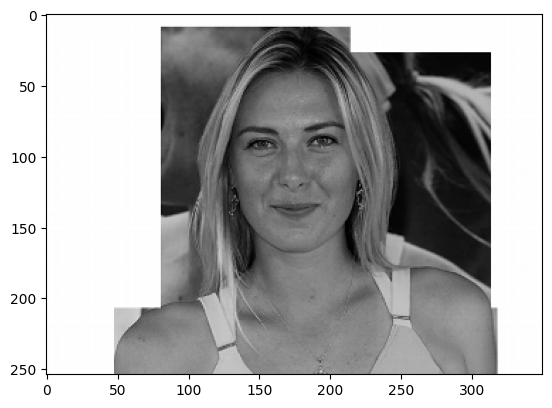

In [8]:
plt.imshow(gray, cmap='gray')

In [9]:
face_cascade = cv2.CascadeClassifier("./opencv/haarcascades/haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("./opencv/haarcascades/haarcascade_eye.xml")

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[120,  50, 111, 111]], dtype=int32)

In [13]:
x,y,w,h = faces[0]
x,y,w,h

(np.int32(120), np.int32(50), np.int32(111), np.int32(111))

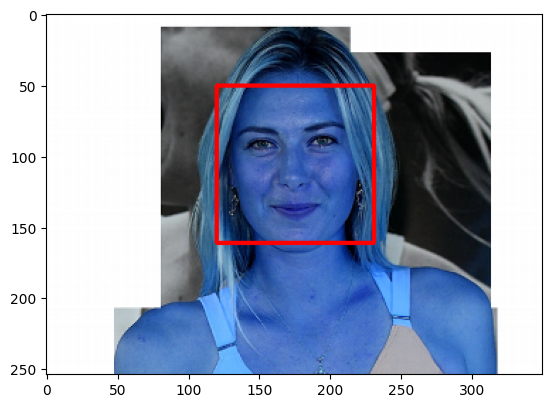

In [12]:
face_img = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
plt.imshow(face_img)

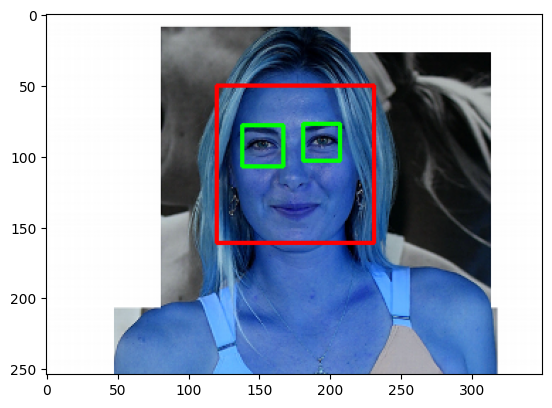

In [14]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

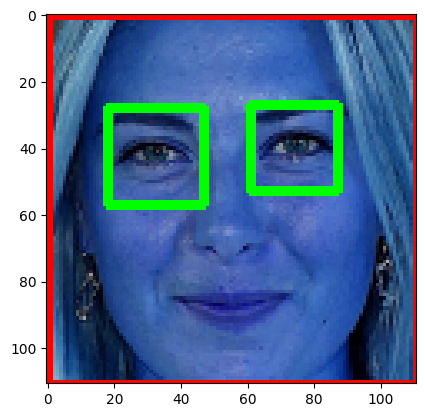

In [15]:
plt.imshow(roi_color, cmap="gray")

In [16]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if (len(eyes)) >= 2:
            return roi_color

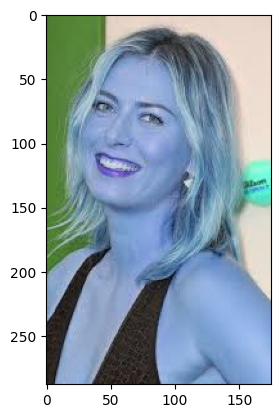

In [21]:
original_image = cv2.imread("./test_images/sharapova1.jpg")
plt.imshow(original_image)

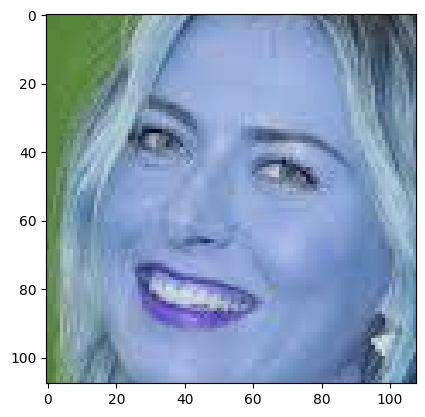

In [23]:
cropped_image = get_cropped_image_if_2_eyes("./test_images/sharapova1.jpg")
plt.imshow(cropped_image)

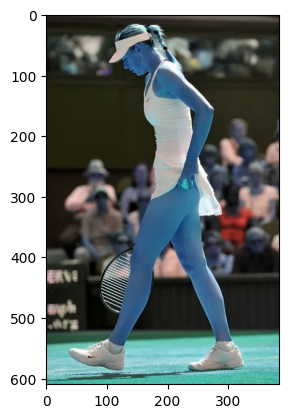

In [28]:
org_image_obstructed = cv2.imread("./test_images/sharapova2.webp")
plt.imshow(org_image_obstructed)

In [31]:
org_image_obstructed = get_cropped_image_if_2_eyes("./test_images/sharapova2.webp")
org_image_obstructed

In [56]:
path_to_data = "./datasets/"
path_to_cr_data = "./datasets/cropped/"

In [80]:
import os
import importlib
from image_scraping import scraping_images

# Reload the module to get the latest version
import image_scraping
importlib.reload(image_scraping)
from image_scraping import scraping_images

# Check if dataset directory exists, if not scrape images first
if not os.path.exists(path_to_data):
    print("Dataset not found. Scraping images...")
    
    query = ["Serena Williams",
             "Lionel Messi", 
             "Maria Sharapova", 
             "Roger Federer", 
             "Virat Kohli"]

    # scraping_images(query, 100)
    print("Images scraped successfully!")

# Now scan for image directories (exclude cropped folder)
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir() and entry.name != 'cropped':
        img_dirs.append(entry.path)

print(f"Found {len(img_dirs)} directories:")
for d in img_dirs:
    print(f"  - {d}")

Found 5 directories:
  - ./datasets/lionel_messi
  - ./datasets/maria_sharapova
  - ./datasets/roger_federer
  - ./datasets/serena_williams
  - ./datasets/virat_kohli


In [81]:
import shutil

if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)

os.mkdir(path_to_cr_data)

In [82]:
cropped_img_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split("/")[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.mkdir(cropped_folder)
                cropped_img_dirs.append(cropped_folder)
                print("Generating cropped image folder: ", cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

lionel_messi
Generating cropped image folder:  ./datasets/cropped/lionel_messi
maria_sharapova
Generating cropped image folder:  ./datasets/cropped/maria_sharapova
maria_sharapova
Generating cropped image folder:  ./datasets/cropped/maria_sharapova
roger_federer
Generating cropped image folder:  ./datasets/cropped/roger_federer
roger_federer
Generating cropped image folder:  ./datasets/cropped/roger_federer
serena_williams
serena_williams
Generating cropped image folder:  ./datasets/cropped/serena_williams
Generating cropped image folder:  ./datasets/cropped/serena_williams
virat_kohli
Generating cropped image folder:  ./datasets/cropped/virat_kohli


In [83]:
import pywt

def w2d(img, mode='haar', level=1):
    # Convert to grayscale and normalize
    imArray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    imArray = np.float32(imArray) / 255.0
    
    # Compute wavelet coefficients
    coeffs = pywt.wavedec2(imArray, mode, level=level)
    
    # Zero out the approximation coefficients
    coeffs[0] *= 0
    
    # Reconstruct image
    imArray_H = pywt.waverec2(coeffs, mode)
    imArray_H = np.uint8(imArray_H * 255)
    
    return imArray_H

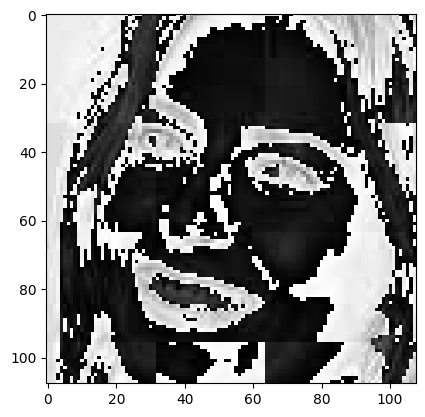

In [84]:
im_har = w2d(cropped_image, 'db1', 5)
plt.imshow(im_har, cmap='gray')

In [85]:
celebrity_file_names_dict

{'lionel_messi': ['./datasets/cropped/lionel_messi/lionel_messi1.png',
  './datasets/cropped/lionel_messi/lionel_messi2.png',
  './datasets/cropped/lionel_messi/lionel_messi3.png',
  './datasets/cropped/lionel_messi/lionel_messi4.png',
  './datasets/cropped/lionel_messi/lionel_messi5.png',
  './datasets/cropped/lionel_messi/lionel_messi6.png',
  './datasets/cropped/lionel_messi/lionel_messi7.png',
  './datasets/cropped/lionel_messi/lionel_messi8.png',
  './datasets/cropped/lionel_messi/lionel_messi9.png',
  './datasets/cropped/lionel_messi/lionel_messi10.png',
  './datasets/cropped/lionel_messi/lionel_messi11.png',
  './datasets/cropped/lionel_messi/lionel_messi12.png',
  './datasets/cropped/lionel_messi/lionel_messi13.png',
  './datasets/cropped/lionel_messi/lionel_messi14.png',
  './datasets/cropped/lionel_messi/lionel_messi15.png',
  './datasets/cropped/lionel_messi/lionel_messi16.png',
  './datasets/cropped/lionel_messi/lionel_messi17.png',
  './datasets/cropped/lionel_messi/lionel

In [86]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count += 1
    
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [88]:
X = []
Y = []

for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scaled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img, 'db1', 5)
        scaled_img_har = cv2.resize(img_har, (32, 32))
        
        # Reshape both images: color is 3072 (32*32*3), grayscale is 1024 (32*32)
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3, 1), scaled_img_har.reshape(32*32, 1)))
        X.append(combined_img)
        Y.append(class_dict[celebrity_name])

In [90]:
len(X[0])

4096

In [91]:
X[0]

array([[116],
       [125],
       [119],
       ...,
       [  1],
       [249],
       [  3]], shape=(4096, 1), dtype=uint8)

In [92]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(150, 4096)

In [93]:
X[0]

array([116., 125., 119., ...,   1., 249.,   3.], shape=(4096,))